# Specific heat capacity


**Code:** #134-000

**File:** `apps/fermi_gas/specific_heat.ipynb
`
**Run it online:** [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Ikergym/MinervaLab/master?filepath=apps%2Ffermi_gas%2Fspecific_heat.ipynb)

-----------

The aim of this notebook is to visualize how to calculate the electronic specific heat from the Fermi-Dirac distribution.

## Interface

The main interface (``main_block_134_000``) is divided two blocks: ``left_block_134_000`` and ``center_block_134_000``. 

``left_block_133_000`` contains the widgets to control the figures: ``metal_dropdown``, ``fermi_energy_text``, ``fermi_temp_text``, ``T_slider``, ``mu_text_absolute``, ``mu_text_relative``, ``approx_dropddown``, ``Cv_text``, ``gamma_text`` and ``show_legend_check``.

``center_block_134_000`` contains two bqplot figures: ``fig_134_001`` and ``fig_134_002``.

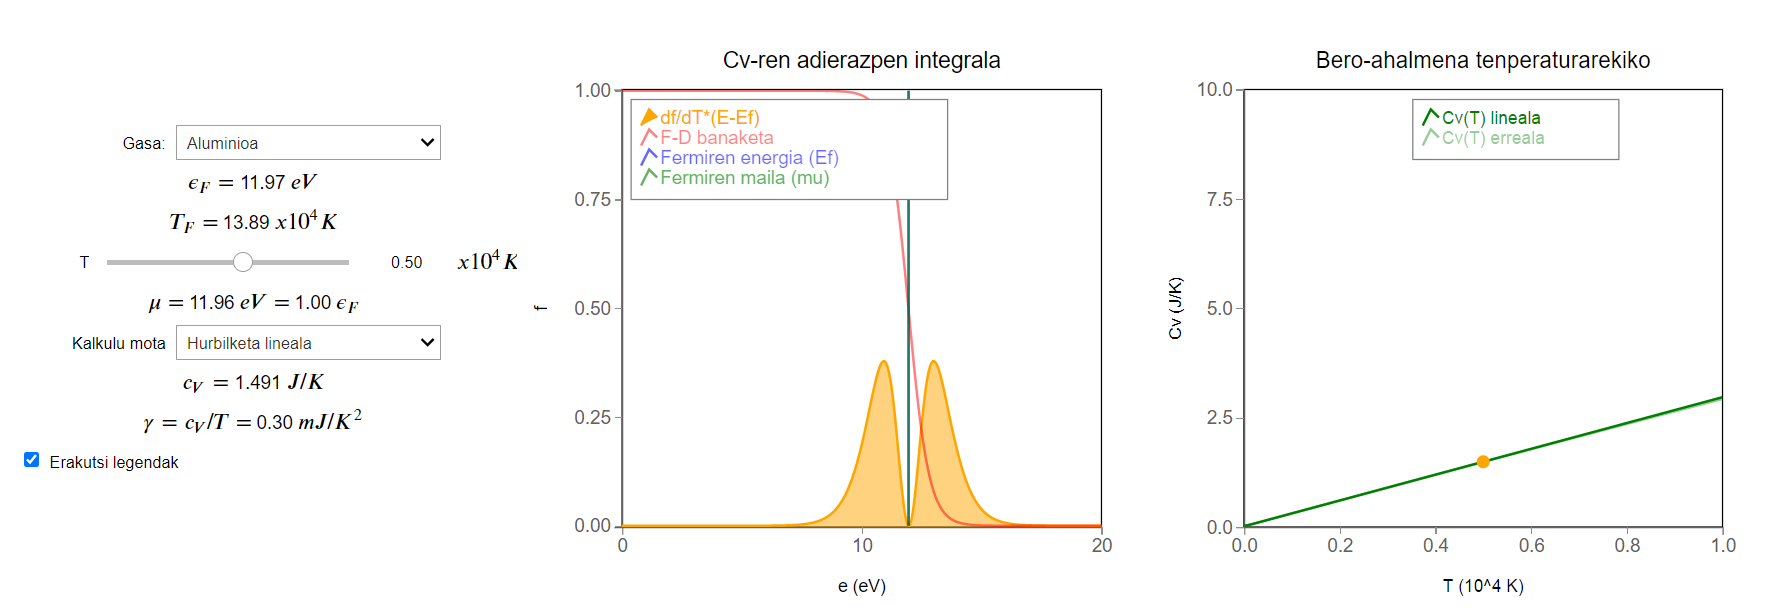

In [2]:
from IPython.display import Image
Image(filename='../../static/images/apps/fermi_gas/134-000.png')

## CSS

A custom `css` file is used to improve the interface of this application. It can be found [here](https://github.com/jongablop/MinervaLab/blob/master/static/custom.css).

In [ ]:
from IPython.display import HTML
display(HTML("<head><link rel='stylesheet' type='text/css' href='./../../static/custom.css'></head>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

## Packages

In [ ]:
import numpy as np

from bqplot import *
import bqplot as bq
import bqplot.marks as bqm
import bqplot.scales as bqs
import bqplot.axes as bqa

import ipywidgets as widgets

## Physical functions

This are the functions that have a physical meaning:
- `get_n`
- `get_Ef`
- `get_mu`
- `get_g`
- `get_FD`
- `get_Cv`
- `convert_Cv_units`
- `get_integrand_exact`
- `get_integrand_linear`

In [ ]:
def get_n(z, dens, mass_mol):
    '''
    This functions calculates the electron density for a
    given metal
    
    Inputs:
    z: integer for number of valence electrons
    dens: float for density of metal in kg/m**3
    mass_mol: float for molar mass in kg
    
    Returns:
    n: float for electron density in A**-3
    '''
    
    n = z*Na * dens/mass_mol *1.0e-30  #Last factor converts m**-3 to A**-3
    return n

In [ ]:
def get_Ef(n):
    '''
    This function calculates the Fermi energy (in eV) for
    a given metal with electron density n.
    
    Inputs:
    n: float for electron density in A**-3
    
    Returns:
    Ef: float for Fermi energy in eV
    '''
    
    Ef = h**2/(2*me)*(3*pi**2*n)**(2.0/3.0) * 1.0e20  # Last factor handles the n in A**-3
    return Ef

In [ ]:
def get_mu(Ef,T):
    '''
    This function calculates the Fermi Level (chemical potential) for
    a metal characterized by Fermi energy Ef at temperature T. This
    calculations is done by applying second order Sommerfeld expansion.
    
    Inputs:
    Ef: float for Fermi energy in eV
    T: float for temperature in 10^4*K
    
    Returns:
    mu: float for Fermi level in eV
    '''
    
    mu = Ef*(1.0-1.0/3.0*(pi*kb*T/2.0/Ef)**2)
    return mu

In [ ]:
def get_g(E):
    '''
    This functions calculates the Density of States (DoS) for a given
    energy, in the free electron gas model.
    
    Inputs:
    E: float for energy in eV
    
    Returns:
    g: number of states for unit of energy and volume (in eV**-1 A**-3)
    '''
    
    if E>0:
        g = me/h**2/pi**2 * np.sqrt(2*me*E/h**2) * 1.0e-30
    else:
        g=0.0
    return g

In [ ]:
def get_FD(Ef, T, mu):
    '''
    This function calculates the F-D distribution values for a 
    metal with Ef and in temperature T, for which mu(T) is already
    calculated.
    
    Inputs:
    Ef: float value for fermi energy (in eV)
    T: float value for temperature (in 10**4 K)
    mu: float value for chemical potential (in eV)
    
    Returns:
    y_values: a 1darray of float values for F-D distribution
    '''
    
    y_values = np.empty(pts)
    overflow = False  # Flag to control overflow with very little exponents
    for i in range(pts):
        if overflow == False:
            E = E_values[i]
            y_values[i] = 1.0/(np.exp((E-mu)/kb/T)+1.0)
            if y_values[i] < 1.0e-20:  # Exponents smaller than -20 considered 0
                overflow = True
        else:
            y_values[i] = 0.0
    
    return y_values

In [ ]:
def get_Cv(integrand):
    '''
    This function calculates the Cv for the current tenperature
    by integrating the given integrand function.
    
    Inputs:
    integrand: float array for the integrand function y values (in 10**-4 K**-1 A**-3)
    
    Returns:
    Cv: float value for specific heat per unit volume (in eV/10**4K /A**3)
    '''
    
    Cv = 0.0
    de = (max(E_values) - min(E_values))/pts
    for i in range(pts):
        E = E_values[i]
        intg = integrand[i]
        Cv = Cv + intg*de
    return Cv

In [ ]:
def convert_Cv_units(Cv,n):
    '''
    Convert from Cv per unit volume in eV/10**4K/A**3
    to Cv per mol in J/K/mol
    
    Inputs:
    Cv: (1darray of) float values of Cv per unit volume (in eV/10**4K /A**3)
    
    Returns:
    Cv_SI: (1d array) of float values Cv per unit mol (in J/K/mol) 
    '''
    
    Cv_SI = Cv/n * 1.602*6.022
    return Cv_SI

In [ ]:
def get_integrand_exact(Ef, T):
    '''
    This function calculates the integrand function for a
    given metal (characterized with Ef) and a given temperature
    T, without any approximation.
    
    Inputs:
    Ef: float value for Fermi energy (in eV)
    T: float value for current temperature (in 10**4 K)
    
    Returns:
    integrand: 1darray of float values for integrand (in 10**-4 K**-1 A**-3)
    '''
    
    mu = get_mu(Ef,T)
    y_values = np.empty(pts)
    y_values_plus = np.empty(pts)
    integrand = np.empty(pts)
    dT = 0.01
    overflow = False  # Flag to control overflow with very little exponents
    for i in range(pts):
        if overflow == False:
            E = E_values[i]
            g = get_g(E)
            y_values[i] = 1.0/(np.exp((E-mu)/kb/T)+1.0)
            y_values_plus[i] = 1.0/(np.exp((E-mu)/kb/(T+dT))+1.0)
            if y_values[i] < 1.0e-20:  # Exponents smaller than -20 considered 0
                overflow = True
        else:
            y_values[i] = 0.0
            y_values_plus[i] = 0.0
        integrand[i] = (y_values_plus[i] - y_values[i]) / dT * (E - Ef)*g
    return integrand

In [ ]:
def get_integrand_linear(Ef, T):
    '''
    This function calculates the integrand function for a
    given metal (characterized with Ef) and a given temperature
    T, approximating mu(T) as Ef and g(E) as g(Ef).
    
    Inputs:
    Ef: float value for Fermi energy (in eV)
    T: float value for current temperature (in 10**4 K)
    
    Returns:
    integrand: 1darray of float values for integrand (in 10**-4 K**-1 A**-3)
    '''
    
    y_values = np.empty(pts)
    y_values_plus = np.empty(pts)
    integrand = np.empty(pts)
    g = get_g(Ef)
    dT = 0.01
    overflow = False  # Flag to control overflow with very little exponents
    for i in range(pts):
        if overflow == False:
            E = E_values[i]
            y_values[i] = 1.0/(np.exp((E-Ef)/kb/T)+1.0)
            y_values_plus[i] = 1.0/(np.exp((E-Ef)/kb/(T+dT))+1.0)
            if y_values[i] < 1.0e-20:  # Exponents smaller than -20 considered 0
                overflow = True
        else:
            y_values[i] = 0.0
            y_values_plus[i] = 0.0
        integrand[i] = (y_values_plus[i] - y_values[i]) / dT * (E - Ef)*g
    return integrand

## Functions related to the interaction

In [ ]:
def show_legend(change):
    '''
    This function controles the visibility of the
    legend of both figures depending on the value of
    the checkbox widget.
    '''
    
    # Read widgets
    show_legend_value = show_legend_check.value
    
    # Update visibility
    FermiIntegrand_001.display_legend=show_legend_value
    FermiDirac_001.display_legend=show_legend_value
    FermiEnergy_001.display_legend=show_legend_value
    ChemicalValue_001.display_legend=show_legend_value
    CvPlotLin_002.display_legend=show_legend_value
    CvPlotExact_002.display_legend=show_legend_value

In [ ]:
def update_approx(approx):
    '''
    This function updates the plot parameters that depend
    on th chosen calculation method (exact or linear approx.)
    '''
    
    if approx:
        CvPlotLin_002.opacities = [1.0]
        CvPlotExact_002.opacities = [0.4]
        FermiIntegrand_001.labels = ['df/dT*(E-Ef)']
    else:
        CvPlotLin_002.opacities = [0.4]
        CvPlotExact_002.opacities = [1.0]
        FermiIntegrand_001.labels = ['df/dT*(E-mu)*g(E)/g(Ef)']
        

In [ ]:
def update_temp(change):
    '''
    This function updates the temperature-dependent marks
    when temperature (or metal) is changed.
    '''
    
    # Read widgets
    T = T_slider.value
    Ef = float(fermi_energy_text.value)
    approx = approx_dropdown.value
    
    # Calculate mu
    mu = get_mu(Ef,T)

    # Calculate F-D distribution and occupancy
    y_values = get_FD(Ef, T, mu)
           
    # Get the integrand for Cv
    if approx:
        integrand = get_integrand_linear(Ef, T)
    else:
        integrand = get_integrand_exact(Ef, T)
    

    # Calculate Cv per electron in SI units
    Cv = get_Cv(integrand)
    g = get_g(Ef)
    n = 2.0/3.0*Ef*g
    Cv = convert_Cv_units(Cv, n)

    # Update curves
    FermiDirac_001.y = y_values
    FermiIntegrand_001.y = integrand/g
    Temperature_001.x = np.full(2, kb*T)
    ChemicalValue_001.x = np.full(2, mu)
    CvMarker_002.x = [T]
    CvMarker_002.y = [Cv]
    update_approx(approx)
        
    # Update output widgets
    mu_text_absolute.value = '%.2f' % mu
    mu_text_relative.value = '%.2f' % (mu/Ef)
    Cv_text.value = '%.3f' % (Cv)
    gamma_text.value = '%.2f' % (Cv/T/10)  # Cv/T/N in mJ/K**2
    
    # Correction for T=0 case
    if T<0.01:
        gamma = 0.9647*0.5*pi**2*kb**2/Ef
        gamma_text.value = '%.2f' % gamma

In [ ]:
def update_metal(change):
    '''
    This functions updates both figures when
    the current metal or approximation method
    is changed.
    '''
    
    # Read widgets
    metal = metal_dropdown.value
    
    # Calculate Ef, Tf and g(Ef)
    rho = metal_densities[metal]
    mass = molar_masses[metal]
    z = valence_numbers[metal]  
    n = get_n(z, rho, mass)
    Ef = get_Ef(n)
    Tf = Ef/kb
    g=get_g(Ef)
    
    # Calculate Cv curve:
    T_values = np.linspace(T_min, T_max, pts_T)
    Cv_exact = np.empty(pts_T)
    Cv_linear = np.empty(pts_T)
    for i in range(pts_T):
        T = T_values[i]
        integrand = get_integrand_exact(Ef, T)
        Cv_exact[i] = get_Cv(integrand)
        integrand = get_integrand_linear(Ef, T)
        Cv_linear[i] = get_Cv(integrand)
    
    # Convert units:
    Cv_exact = convert_Cv_units(Cv_exact, n)
    Cv_linear = convert_Cv_units(Cv_linear, n)

    # Update curves
    FermiEnergy_001.x = np.full(2, Ef)
    CvPlotExact_002.y = Cv_exact
    CvPlotLin_002.y = Cv_linear
    
    # Update output widgets
    fermi_energy_text.value = '%.2f' % Ef
    fermi_temp_text.value = '%.2f' % Tf
    
    # Update temperature dependent parameters
    update_temp(None)

## Main interface

In [ ]:
#######################
###   PARAMETERS    ###
#######################

# Universal constant (only used to get Ef and g)
h = 6.5821e-16 #Planck's reduced constant in eV*s
c = 3.0e8 # Speed of Light in m/s
me = 510998.9/c**2 # Electron mass in eV/c**2
Na = 6.0221e23
kb = 8.617e-1 # Boltzmann's constant in eV/(10**4 K).
pi =  np.pi

# Plot parameters (temperatures in 10**4 K)
pts = 2000 # Number of points to calculate
pts_T = 400 # Number of points to calculate on Cv vs T graph
T_min = 0.001 # Minimun T value on slider
T_max = 1.0 # Maximun T value on slider
T_step = 0.1 # Step for T slider

# Metal data:(data obtained from Wikipedia)
metal_labels = ["Sodioa", "Aluminioa", "Burdina", "Kobrea"] 
metal_densities = [968.0, 2700.0, 7874.0, 8960.0] # In kg/m**3
molar_masses = [0.0229, 0.026, 0.0558, 0.0635] # In Kg
valence_numbers = [1, 3, 2, 1]

# Initial values
T = 0.5  # Initial T value
metal = 1 # Initial metal index {0: 'Na', 1: 'Al', 2: 'Fe', 3: 'Cu'}

# Figures xRanges
E_values = np.linspace(-50.0,50.0,pts)
T_values = np.linspace(T_min, T_max, pts_T)

In [ ]:
########################
###CREATE THE FIGURES###
########################

fig_134_001 = bq.Figure(title='Cv-ren adierazpen integrala',
                marks=[],
                axes=[],
                padding_y = 0.0,
                animation_duration=0,
                legend_location='top-right',
                legend_style= {'fill': 'white', 'stroke': 'grey'},
                legend_text= {'font-size':15},
                background_style= {'fill': 'white',  'stroke': 'black'},
                fig_margin=dict(top=70, bottom=60, left=80, right=30),
                layout = widgets.Layout(width='50%'),
                toolbar = True,
    )

fig_134_002 = bq.Figure(title='Bero-ahalmena tenperaturarekiko',
                marks=[],
                axes=[],
                padding_x = 0.0,
                padding_y = 0.0,
                animation_duration=0,
                legend_location='top-right',
                legend_style= {'fill': 'white', 'stroke': 'grey'},
                background_style= {'fill': 'white',  'stroke': 'black'},
                fig_margin=dict(top=70, bottom=60, left=80, right=30),
                layout = widgets.Layout(width='50%'),
                toolbar = True,
    )

scale_x_001 = bqs.LinearScale(min = 0.0, max = 20.0)
scale_y_001 = bqs.LinearScale(min = 0.0, max = 1.0)
scale_x_002 = bqs.LinearScale(min = 0.0, max = T_max, allow_padding=False)
scale_y_002 = bqs.LinearScale(min = 0.0, max = 10.0, allow_padding=False)

axis_x_001 = bqa.Axis(scale=scale_x_001,
                tick_format='.0f',#'0.2f',
                tick_style={'font-size': '15px'},
                #tick_values = np.linspace(p_min, p_max, 7),
                num_ticks=3,
                grid_lines = 'none',
                grid_color = '#8e8e8e', 
                label='e (eV)',
                label_location='middle',
                label_style={'stroke': 'black', 'default-size': 35},
                label_offset='50px')

axis_y_001 = bqa.Axis(
                scale=scale_y_001,
                tick_format='0.2f',
                tick_style={'font-size': '15px'},
                tick_values=np.linspace(0.0,1.0,5),
                grid_lines = 'none',
                grid_color = '#8e8e8e', 
                orientation='vertical',
                label='f',
                label_location='middle',
                label_style={'stroke': 'red', 'default_size': 35},
                label_offset='60px')

axis_x_002 = bqa.Axis(scale=scale_x_002,
                tick_format='.1f',#'0.2f',
                tick_style={'font-size': '15px'},
                tick_values = np.linspace(0.0,T_max,6),
                grid_lines = 'none',
                grid_color = '#8e8e8e', 
                label='T (10^4 K)',
                label_location='middle',
                label_style={'stroke': 'black', 'default-size': 35},
                label_offset='50px')

axis_y_002 = bqa.Axis(
                scale=scale_y_002,
                tick_format='.1f',#'0.2f',
                tick_style={'font-size': '15px'},
                tick_values = np.linspace(0.0,10.0, 5),
                grid_lines = 'none',
                grid_color = '#8e8e8e', 
                orientation='vertical',
                label='Cv (J/K)',
                label_location='middle',
                label_style={'stroke': 'red', 'default_size': 35},
                label_offset='50px')


fig_134_001.axes = [axis_x_001, axis_y_001]
fig_134_002.axes = [axis_x_002, axis_y_002]


########################
####CREATE THE MARKS####
########################

FermiIntegrand_001 = bqm.Lines(
                x = E_values,
                y = np.empty(pts),
                scales = {'x': scale_x_001, 'y': scale_y_001},
                opacities = [1.0],
                visible = True,
                colors = ['orange'],
                fill = 'bottom',
                fill_colors = ['orange'],
                fill_opacities = [0.5],
                labels = ['df/dT*(E-Ef)'],
                display_legend = True,
)

FermiDirac_001 = bqm.Lines(
                x = E_values, 
                y = np.empty(pts), 
                scales = {'x': scale_x_001, 'y': scale_y_001}, 
                opacities = [0.5],
                visible = True, #True, #t == '1.00',
                colors = ['red'],
                labels = ['F-D banaketa'],
                display_legend = True,
)

FermiEnergy_001 = bqm.Lines(
                x = np.empty(2),
                y = np.linspace(0.0,1.0,2),
                scales = {'x': scale_x_001, 'y': scale_y_001},
                opacities = [0.6],
                visible = True,
                colors = ['blue'],
                labels = ['Fermiren energia (Ef)'],
                display_legend = True,
                
)

ChemicalValue_001 = bqm.Lines(
                x = np.empty(2),
                y = np.linspace(0.0,1.0,2),
                scales = {'x': scale_x_001, 'y': scale_y_001},
                opacities = [0.6],
                visible = True,
                colors = ['green'],
                labels = ['Fermiren maila (mu)'],
                display_legend = True,
)

Temperature_001 = bqm.Lines(
                x = np.empty(2),
                y = np.linspace(0.0,1.0,2),
                scales = {'x': scale_x_001, 'y': scale_y_001},
                opacities = [0.6],
                visible = False,
                colors = ['orange'],
                labels = ['k_B T'],
                display_legend = False,
)

CvPlotLin_002 = bqm.Lines(
                x = T_values,
                y = [],
                scales = {'x': scale_x_002, 'y': scale_y_002},
                opacities = [0.4],
                visible = True,
                colors = ['green'], # maybe #45c400
                labels = ['Cv(T) lineala'],
                display_legend = True,
)

CvPlotExact_002 = bqm.Lines(
                x = T_values,
                y = [],
                scales = {'x': scale_x_002, 'y': scale_y_002},
                opacities = [1.0],
                visible = True,
                colors = ['green'],
                labels = ['Cv(T) erreala'],
                display_legend = True,
)

CvMarker_002 = bqm.Scatter(
                x = [], 
                y = [], 
                scales = {'x': scale_x_002, 'y': scale_y_002}, 
                opacities = [1.0],
                visible = True, #True, #t == '1.00',
                colors = ['orange'],
                labels = ['Cv'],
                display_legend = False
)



fig_134_001.marks = [FermiIntegrand_001, FermiDirac_001, FermiEnergy_001, ChemicalValue_001, Temperature_001]
fig_134_002.marks = [CvPlotLin_002, CvPlotExact_002, CvMarker_002]


########################
######  WIDGETS  #######
########################

## Input Widgets ##

T_slider = widgets.FloatSlider(
    min=T_min,
    max=T_max,
    step=T_step,
    value=T,
    description='T',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout = widgets.Layout(width='90%'),
)

T_slider.observe(update_temp, 'value')

metal_dropdown = widgets.Dropdown(
    options=[('Sodioa', 0), ('Aluminioa', 1), ('Burdina', 2), ('Kobrea', 3)],
    value=metal,
    description='Gasa:',
    disabled=False,
)

metal_dropdown.observe(update_metal, 'value') 

approx_dropdown = widgets.Dropdown(
    options=[('Hurbilketa lineala',True), ('Kalkulu zehatza',False)],
    value=True,
    description='Kalkulu mota',
    disabled=False
)

approx_dropdown.observe(update_temp, 'value')

show_legend_check = widgets.Checkbox(
    description='Erakutsi legendak',
    disabled=False,
    value=True,
)

show_legend_check.observe(show_legend, 'value')


## Output Widgets ##

fermi_energy_text = widgets.Label(value='')
fermi_temp_text = widgets.Label(value='')
mu_text_absolute = widgets.Label(value='')
mu_text_relative = widgets.Label(value='')
Cv_text = widgets.Label(value='')
gamma_text = widgets.Label(value='')


########################
###  INIT FIGURES  ####
########################

update_metal(None) # Read widgets values and assign marks' x,y values


########################
######  LAYOUT  ########
########################

left_block_134_000 = widgets.VBox([], layout=widgets.Layout(width='30%', align_self='center', align_items='center'))
left_block_134_000.children = [metal_dropdown,
                               widgets.HBox([widgets.Label(value='$\epsilon_F=$'),fermi_energy_text,widgets.Label(value='$eV$')]),
                               widgets.HBox([widgets.Label(value='$T_F=$'),fermi_temp_text,widgets.Label(value='$x10^4 K$')]),
                               widgets.HBox([T_slider, widgets.Label(value='$x10^4 K$')], layout=widgets.Layout(width='100%')),
                               widgets.HBox([widgets.Label(value='$\mu=$'),mu_text_absolute,widgets.Label(value='$eV = $'),
                                             mu_text_relative,widgets.Label(value='$\epsilon_F$')]),
                               approx_dropdown, widgets.HBox([widgets.Label(value='$c_V=$'),Cv_text,widgets.Label('$J/K$')]),
                               widgets.HBox([widgets.Label(value='$\gamma = c_V/T =$'), gamma_text, widgets.Label('$mJ/K^2$')]),
                               show_legend_check
                              ]

center_block_134_000 = widgets.HBox([], layout=widgets.Layout(width='70%', align_self='center', align_items='center'))
center_block_134_000.children = [fig_134_001, fig_134_002]

main_block_134_000 = widgets.HBox([], layout=widgets.Layout(width='100%', align_self='center', align_items='center'))
main_block_134_000.children = [left_block_134_000, center_block_134_000]

main_block_134_000